In [1]:
!nvidia-smi

Sat Aug 14 18:53:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
!pip install torchaudio -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1.9 MB 5.9 MB/s 


In [2]:
#download dataset
import gdown
ESC50_url = "https://drive.google.com/uc?export=download&id=1wyapym3pyPG20ruSgVUBS0XHZmO6IYBX"

output = "/content/ESC-50-master.zip"
gdown.download(ESC50_url, output,quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1wyapym3pyPG20ruSgVUBS0XHZmO6IYBX
To: /content/ESC-50-master.zip
646MB [00:04, 148MB/s]


'/content/ESC-50-master.zip'

In [3]:
#unzip dataset
!unzip -qq ESC-50-master.zip

In [4]:
import pandas as pd
'''
esc50_df = []
for i in range(10):
  esc50_df.append([])
'''
esc50_dict = {"fname" : [], "label" : [], "fold" : []}
csvData = pd.read_csv("/content/ESC-50-master/meta/esc50.csv")

for i in range(0, len(csvData)):
  if csvData.iloc[i, 2] == 42:   #class siren
    esc50_dict["fname"].append(csvData.iloc[i, 0])
    esc50_dict["label"].append(0)
    esc50_dict["fold"].append(csvData.iloc[i, 1])

  elif csvData.iloc[i, 2] == 37:  #class clock_alarm
    esc50_dict["fname"].append(csvData.iloc[i, 0])
    esc50_dict["label"].append(1)
    esc50_dict["fold"].append(csvData.iloc[i, 1])

  elif csvData.iloc[i, 2] == 25:  #class footsteps
    esc50_dict["fname"].append(csvData.iloc[i, 0])
    esc50_dict["label"].append(2)
    esc50_dict["fold"].append(csvData.iloc[i, 1])

  elif csvData.iloc[i, 2] == 20:  #class crying_baby
    esc50_dict["fname"].append(csvData.iloc[i, 0])
    esc50_dict["label"].append(3)
    esc50_dict["fold"].append(csvData.iloc[i, 1])

  elif csvData.iloc[i, 2] == 30:  #class door_knock
    esc50_dict["fname"].append(csvData.iloc[i, 0])
    esc50_dict["label"].append(4)
    esc50_dict["fold"].append(csvData.iloc[i, 1])

  elif csvData.iloc[i, 2] == 22:  #class clapping
    esc50_dict["fname"].append(csvData.iloc[i, 0])
    esc50_dict["label"].append(5)
    esc50_dict["fold"].append(csvData.iloc[i, 1])

  elif csvData.iloc[i, 2] == 24:  #class coughing
    esc50_dict["fname"].append(csvData.iloc[i, 0])
    esc50_dict["label"].append(6)
    esc50_dict["fold"].append(csvData.iloc[i, 1])

  elif csvData.iloc[i, 2] == 0:  #class dog
    esc50_dict["fname"].append(csvData.iloc[i, 0])
    esc50_dict["label"].append(7)
    esc50_dict["fold"].append(csvData.iloc[i, 1])

  elif csvData.iloc[i, 2] == 44:  #class engine
    esc50_dict["fname"].append(csvData.iloc[i, 0])
    esc50_dict["label"].append(8)
    esc50_dict["fold"].append(csvData.iloc[i, 1])

  elif csvData.iloc[i, 2] == 40:  #class helicopter
    esc50_dict["fname"].append(csvData.iloc[i, 0])
    esc50_dict["label"].append(9)
    esc50_dict["fold"].append(csvData.iloc[i, 1])

In [5]:
print("num of data: ", len(esc50_dict["fname"]))
print("file name: ", esc50_dict["fname"][0])
print("class idx: ", esc50_dict["label"][0])
print("fold: ", esc50_dict["fold"][0])

num of data:  400
file name:  1-100032-A-0.wav
class idx:  7
fold:  1


In [8]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)

  # ----------------------------
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))

  # ----------------------------
  # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

  # ----------------------------
  # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

  # ----------------------------
  # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

  # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

  # ----------------------------
  # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [18]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, fdict, data_path):
    self.fdict = fdict
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.fdict["fname"])   
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    audio_file = self.data_path + self.fdict["fname"][idx]
    # Get the Class ID
    class_id = self.fdict["label"][idx]

    aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same 
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

In [19]:
from torch.utils.data import random_split

#data_path = '/content/UrbanSound8K/audio'
data_path = "/content/ESC-50-master/audio/"

myds = SoundDS(esc50_dict, data_path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [14]:
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0

    # Repeat for each batch in the training set
    for i, data in enumerate(train_dl):
        # Get the input features and target labels, and put them on the GPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # Normalize the inputs
        inputs_m, inputs_s = inputs.mean(), inputs.std()
        inputs = (inputs - inputs_m) / inputs_s

        # Zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep stats for Loss and Accuracy
        running_loss += loss.item()

        # Get the predicted class with the highest score
        _, prediction = torch.max(outputs,1)
        # Count of predictions that matched the target label
        correct_prediction += (prediction == labels).sum().item()
        total_prediction += prediction.shape[0]

        #if i % 10 == 0:    # print every 10 mini-batches
        #    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
    
    # Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc:.2f}')

  print('Finished Training')

In [16]:
weight_url = "https://drive.google.com/uc?export=download&id=1c2aj1k3HMwvsLN-LwhCzenE-2OV41Vlk"
gdown.download(weight_url, "/content/audio40.pth", quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1c2aj1k3HMwvsLN-LwhCzenE-2OV41Vlk
To: /content/audio40.pth
100%|██████████| 115k/115k [00:00<00:00, 29.5MB/s]


'/content/audio40.pth'

In [20]:
num_epochs = 20
myModel.load_state_dict(torch.load('/content/audio40.pth'))
training(myModel, train_dl, num_epochs)

Epoch: 0, Loss: 5.14, Accuracy: 0.08
Epoch: 1, Loss: 4.26, Accuracy: 0.14
Epoch: 2, Loss: 3.25, Accuracy: 0.25
Epoch: 3, Loss: 2.35, Accuracy: 0.31
Epoch: 4, Loss: 1.72, Accuracy: 0.44
Epoch: 5, Loss: 1.34, Accuracy: 0.53
Epoch: 6, Loss: 1.12, Accuracy: 0.60
Epoch: 7, Loss: 1.05, Accuracy: 0.64
Epoch: 8, Loss: 0.91, Accuracy: 0.70
Epoch: 9, Loss: 0.76, Accuracy: 0.73
Epoch: 10, Loss: 0.70, Accuracy: 0.75
Epoch: 11, Loss: 0.67, Accuracy: 0.77
Epoch: 12, Loss: 0.69, Accuracy: 0.75
Epoch: 13, Loss: 0.64, Accuracy: 0.79
Epoch: 14, Loss: 0.57, Accuracy: 0.80
Epoch: 15, Loss: 0.68, Accuracy: 0.76
Epoch: 16, Loss: 0.66, Accuracy: 0.79
Epoch: 17, Loss: 0.56, Accuracy: 0.79
Epoch: 18, Loss: 0.60, Accuracy: 0.80
Epoch: 19, Loss: 0.58, Accuracy: 0.80
Finished Training


In [21]:
torch.save(myModel.state_dict(), '/content/esc_subset-20.pth')

In [22]:
num_epochs=20
training(myModel, train_dl, num_epochs)

Epoch: 0, Loss: 0.57, Accuracy: 0.81
Epoch: 1, Loss: 0.60, Accuracy: 0.78
Epoch: 2, Loss: 0.53, Accuracy: 0.80
Epoch: 3, Loss: 0.55, Accuracy: 0.81
Epoch: 4, Loss: 0.49, Accuracy: 0.82
Epoch: 5, Loss: 0.52, Accuracy: 0.83
Epoch: 6, Loss: 0.49, Accuracy: 0.82
Epoch: 7, Loss: 0.41, Accuracy: 0.85
Epoch: 8, Loss: 0.46, Accuracy: 0.85
Epoch: 9, Loss: 0.42, Accuracy: 0.86
Epoch: 10, Loss: 0.34, Accuracy: 0.88
Epoch: 11, Loss: 0.33, Accuracy: 0.89
Epoch: 12, Loss: 0.37, Accuracy: 0.88
Epoch: 13, Loss: 0.32, Accuracy: 0.89
Epoch: 14, Loss: 0.39, Accuracy: 0.86
Epoch: 15, Loss: 0.33, Accuracy: 0.90
Epoch: 16, Loss: 0.33, Accuracy: 0.90
Epoch: 17, Loss: 0.34, Accuracy: 0.89
Epoch: 18, Loss: 0.25, Accuracy: 0.92
Epoch: 19, Loss: 0.29, Accuracy: 0.92
Finished Training


In [23]:
torch.save(myModel.state_dict(), '/content/esc_subset-40.pth')

In [24]:
num_epochs=20
training(myModel, train_dl, num_epochs)

Epoch: 0, Loss: 0.26, Accuracy: 0.94
Epoch: 1, Loss: 0.35, Accuracy: 0.89
Epoch: 2, Loss: 0.31, Accuracy: 0.89
Epoch: 3, Loss: 0.32, Accuracy: 0.92
Epoch: 4, Loss: 0.32, Accuracy: 0.89
Epoch: 5, Loss: 0.33, Accuracy: 0.89
Epoch: 6, Loss: 0.32, Accuracy: 0.90
Epoch: 7, Loss: 0.29, Accuracy: 0.89
Epoch: 8, Loss: 0.29, Accuracy: 0.90
Epoch: 9, Loss: 0.24, Accuracy: 0.94
Epoch: 10, Loss: 0.21, Accuracy: 0.94
Epoch: 11, Loss: 0.24, Accuracy: 0.94
Epoch: 12, Loss: 0.23, Accuracy: 0.94
Epoch: 13, Loss: 0.28, Accuracy: 0.92
Epoch: 14, Loss: 0.24, Accuracy: 0.92
Epoch: 15, Loss: 0.21, Accuracy: 0.95
Epoch: 16, Loss: 0.27, Accuracy: 0.91
Epoch: 17, Loss: 0.21, Accuracy: 0.94
Epoch: 18, Loss: 0.27, Accuracy: 0.90
Epoch: 19, Loss: 0.21, Accuracy: 0.95
Finished Training


In [25]:
torch.save(myModel.state_dict(), '/content/esc_subset-60.pth')

In [30]:
# ----------------------------
# Inference(evaluation)
# ----------------------------

def evaluation (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:
      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
 
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc:.2f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
evaluation(myModel, val_dl)

Accuracy: 0.80, Total items: 80


In [31]:
y_pred = []
y_true = []

for data in val_dl:
  inputs, labels = data[0].to(device), data[1].to(device)

  inputs_m, inputs_s = inputs.mean(), inputs.std()
  inputs = (inputs - inputs_m) / inputs_s

  outputs = myModel(inputs)

  outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
  y_pred.extend(outputs)

  labels = labels.data.cpu().numpy()
  y_true.extend(labels)

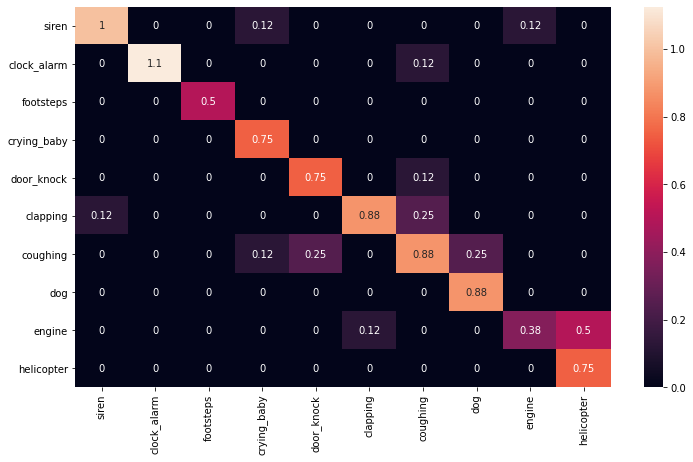

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

classes = ('siren', 'clock_alarm', 'footsteps', 'crying_baby', 'door_knock',
      'clapping', 'coughing', 'dog', 'engine', 'helicopter')

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [33]:
sr = 44100
channel = 2
duration = 4000

aud = AudioUtil.open('/content/ESC-50-master/audio/1-104089-B-22.wav')

reaud = AudioUtil.resample(aud, sr)
rechan = AudioUtil.rechannel(reaud, channel)
dur_aud = AudioUtil.pad_trunc(rechan, duration)

sgram = AudioUtil.spectro_gram(dur_aud, n_mels=64, n_fft=1024, hop_len=None)
#return aug_sgram, class_id
with torch.no_grad():
  input = sgram.to(device)
  output = myModel(input.unsqueeze(0))
  prediction = torch.max(output,1)

In [34]:
output

tensor([[-0.2782, -0.8931,  0.2008,  0.6786, -0.0713,  0.2317, -2.3266, -0.0340,
         -0.2378,  0.5039]], device='cuda:0')